<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Watson Machine Learning engine

This notebook shows hot to create a data mart for Watson Machine Learning deployments. It includes steps for performance, bias and quality monitor configurations.

Contents
- [1. Setup](#setup)
- [2. Binding machine learning engine](#binding)
- [3. Subscriptions](#subscription)
- [4. Quality monitoring](#quality)
- [5. Performance monitoring](#performance)
- [6. Fairness monitoring](#fairness)
- [7. Data Mart](#datamart)

<a id="setup"></a>
## 1. Setup

### 1.1 Installation and authentication

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1

Requirement not upgraded as not directly required: docutils>=0.10 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk->watson-machine-learning-client->ibm-ai-openscale)


In [2]:
!pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1

Requirement not upgraded as not directly required: docutils>=0.10 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk->watson-machine-learning-client)


#### ACTION: Restart kernel to make sure installed versions are used.

Import and initiate.

In [51]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

#### ACTION: Get AI OpenScale `instance_guid` and `apikey`

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

How to get your AI OpenScale instance GUID

- if your resource group is different than `default` switch to resource group containing AI OpenScale instance
```
bx target -g <myResourceGroup>
```
- get details of the instance
```
bx resource service-instance 'AI-OpenScale-instance_name'
```

#### Let's define some constants required to set up data mart:

- AIOS_CREDENTIALS (AI OpenScale credentials)
- POSTGRES_CREDENTIALS
- SCHEMA_NAME
- WML_CREDENTIALS (Watson Machine Learning credentials)

In [4]:
AIOS_CREDENTIALS = {
  "instance_guid": "*****",
  "apikey": "*****", 
  "url": "https://api.aiopenscale.cloud.ibm.com"
}

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
WML_CREDENTIALS =  {
  "apikey": "***",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/181ed6cc388f47bd9d862fe066f9cfce:c419e24a-c4eb-41b4-a2e1-ce4f0d298428::",
  "iam_apikey_name": "auto-generated-apikey-33f864a1-9958-4a32-b9ab-6fd962f98522",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/181ed6cc388f47bd9d862fe066f9cfce::serviceid:ServiceId-e847629a-195e-455d-a949-957263b867ab",
  "instance_id": "***",
  "password": "***",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "*****"
}

In [62]:
# The code was removed by Watson Studio for sharing.

In [8]:
POSTGRES_CREDENTIALS = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [9]:
# The code was removed by Watson Studio for sharing.

In [64]:
SCHEMA_NAME = 'data_mart_cars4u_tutorial'

You can use the code below to create the schema. If the schema already exists skipp this cell.

In [65]:
create_postgres_schema(postgres_credentials=POSTGRES_CREDENTIALS, schema_name=SCHEMA_NAME)

In [66]:
client = APIClient(aios_credentials=AIOS_CREDENTIALS)

In [67]:
client.version

'1.0.287'

### 1.2 DataMart setup

In [69]:
client.data_mart.setup(db_credentials=POSTGRES_CREDENTIALS, schema=SCHEMA_NAME)

In [70]:
data_mart_details = client.data_mart.get_details()

Data Mart with instance guid name has been created.

<a id="binding"></a>

## 2. Bind machine learning engines

### 2.1 Bind Watson Machine Learning 

You can bind you Watson Machine Learning instance to previously created data mart.

In [71]:
binding_uid = client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(WML_CREDENTIALS))

In [72]:
bindings_details = client.data_mart.bindings.get_details()

In [73]:
client.data_mart.bindings.list()

4d7a90a8-9df1-45be-be13-cb54930512cf,WML instance,watson_machine_learning,2018-12-13T15:29:01.328Z


### 2.2 Check available assets from binded services

#### List available assets

In [74]:
client.data_mart.bindings.list_assets()

67d1d82d-eeb0-488a-b403-1a8dc00db72f,CARS4U - Action Recommendation Model,2018-12-13T15:27:03.277Z,model,mllib-2.1,4d7a90a8-9df1-45be-be13-cb54930512cf,False


#### Get metadata of available assets

In [75]:
assets_details = client.data_mart.bindings.get_asset_details()

In [76]:
cars4u_asset_uid = None

for x in client.data_mart.bindings.get_asset_details():
    if 'cars4u' in x['name'].lower():
        cars4u_asset_uid = x['source_uid']

In [77]:
print(str(cars4u_asset_uid))

67d1d82d-eeb0-488a-b403-1a8dc00db72f


<a id="subscriptions"></a>
## 3. Subscriptions

### 3.1 Subscribe the asset

In [78]:
subscription = client.data_mart.subscriptions.add(WatsonMachineLearningAsset(cars4u_asset_uid))

**Note:** By default, payload logging and performance monitoring are enabled.

#### Get subscriptions list

In [79]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['67d1d82d-eeb0-488a-b403-1a8dc00db72f']


#### List subscriptions

In [80]:
client.data_mart.subscriptions.list()

67d1d82d-eeb0-488a-b403-1a8dc00db72f,CARS4U - Action Recommendation Model,model,4d7a90a8-9df1-45be-be13-cb54930512cf,2018-12-13T15:29:10.858Z


#### Get subscription

**Hint:** You can get subscription by passing subscription_uid to below method.

<a id="quality"></a>
## 4. Quality monitoring and feedback logging

### 4.1 Quality monitoring setup

#### Enable quality monitor for selected subscription

You need to provide the monitoring `threshold` and `min_records` (minimal number of feedback records).

In [81]:
subscription.quality_monitoring.enable(problem_type=ProblemType.MULTICLASS_CLASSIFICATION, threshold=0.7, min_records=5)

### 4.2 Feedback logging

#### Send some feedback records to feedback store. 

Feedback records are used to evaluate our model.

In [82]:
subscription.feedback_logging.store(
            [
                [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'Voucher'],
                [178, 'Female', 'M', 2, 55, 'Active', 'No', 'what customer service? It was a nightmare', 0, 'Product: Information', 'Free Upgrade'],
                [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'NA'],
                [123, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'Voucher'],
                [178, 'Female', 'M', 2, 55, 'Active', 'No', 'what customer service? It was a nightmare', 0, 'Product: Information', 'Free Upgrade'],
                [124, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'NA'],
                [3785, 'Male', 'S', 1, 17, 'Inactive', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information', 'On-demand pickup location'],
                [3786, 'Male', 'S', 1, 17, 'Inactive', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information', 'On-demand pickup location'],
                [3787, 'Male', 'S', 1, 17, 'Active', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information', 'On-demand pickup location'],
                [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'Voucher'],
                [178, 'Female', 'M', 2, 55, 'Active', 'No', 'what customer service? It was a nightmare', 0, 'Product: Information', 'Free Upgrade'],
                [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning', 'NA']
            ],
            fields=['ID', 'Gender', 'Status', 'Children', 'Age', 'Customer_Status', 'Car_Owner', 'Customer_Service', 'Satisfaction', 'Business_Area', 'Action']
        )

#### Preview table schema and content

In [83]:
subscription.feedback_logging.print_table_schema()

ID,integer,True
Gender,string,True
Status,string,True
Children,integer,True
Age,double,True
Customer_Status,string,True
Car_Owner,string,True
Customer_Service,string,True
Satisfaction,integer,True
Business_Area,string,True
Action,string,True


In [84]:
subscription.feedback_logging.show_table()

122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,Voucher,2018-12-13 15:29:12.321000+00:00
178,Female,M,2,55.0,Active,No,what customer service? It was a nightmare,0,Product: Information,Free Upgrade,2018-12-13 15:29:12.321000+00:00
122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,NA,2018-12-13 15:29:12.321000+00:00
123,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,Voucher,2018-12-13 15:29:12.321000+00:00
178,Female,M,2,55.0,Active,No,what customer service? It was a nightmare,0,Product: Information,Free Upgrade,2018-12-13 15:29:12.321000+00:00
124,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,NA,2018-12-13 15:29:12.321000+00:00
3785,Male,S,1,17.0,Inactive,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,On-demand pickup location,2018-12-13 15:29:12.321000+00:00
3786,Male,S,1,17.0,Inactive,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,On-demand pickup location,2018-12-13 15:29:12.321000+00:00
3787,Male,S,1,17.0,Active,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,On-demand pickup location,2018-12-13 15:29:12.321000+00:00
122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,Voucher,2018-12-13 15:29:12.321000+00:00


Note: First 10 records were displayed.


### 4.3 Run quality monitor on demand

**Hint:** Accuracy (Quality) monitor is executed every hour. You can also run it on demand using below command.

In [85]:
run_details = subscription.quality_monitoring.run()

You can also check evaluation run details using below command. The code below has a timeout set to 60 seconds.

In [86]:
status = run_details['status']
id = run_details['id']

print("Run status: {}".format(status))

start_time = time.time()
elapsed_time = 0

while status != 'completed' and elapsed_time < 60:
    time.sleep(10)
    run_details = subscription.quality_monitoring.get_run_details(run_uid=id)
    status = run_details['status']
    elapsed_time = time.time() - start_time
    print("Run status: {}".format(status))

Run status: running
Run status: running
Run status: completed


### 4.4 Show the quality metrics

In [87]:
subscription.quality_monitoring.show_table()

2018-12-13 15:29:13.498000+00:00,0.5,0.7,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,Accuracy_evaluation_42b3353a-96dd-4819-b10d-f2968aae8589,


In [88]:
deployment_uid = deployment_uid = subscription.get_deployment_uids()[0]

subscription.quality_monitoring.get_metrics(deployment_uid=deployment_uid)

{'end': '2018-12-13T15:29:38.458571Z',
 'metrics': [{'process': 'Accuracy_evaluation_42b3353a-96dd-4819-b10d-f2968aae8589',
   'timestamp': '2018-12-13T15:29:13.498Z',
   'value': {'metrics': [{'name': 'weightedTruePositiveRate', 'value': 0.5},
     {'name': 'accuracy', 'value': 0.5},
     {'name': 'weightedFMeasure', 'value': 0.625},
     {'name': 'weightedRecall', 'value': 0.5},
     {'name': 'weightedFalsePositiveRate', 'value': 0.0},
     {'name': 'weightedPrecision', 'value': 1.0}],
    'quality': 0.5,
    'threshold': 0.7}}],
 'start': '2018-12-13T14:29:10.858Z'}

<a id="performance"></a>
## 5. Performance monitoring

Payload logging and performance monitoring are enabled by default during subscription creation. Both run on top of payload logging table.

### 5.1 Payload logging

For Watson Machine Learning engine each scoring request is automatically logged in payload logging table.

#### Score deployed model using `watson-machine-learning-client`

 Documentation for the `watson-machine-learning-client` can be found [here](wml-api-pyclient.mybluemix.net)

In [89]:
wml_client = client.data_mart.bindings.get_native_engine_client(binding_uid=binding_uid)

Let's extract scoring_ednpoints for both deployments.

In [90]:
cars4u_scoring_endpoint = None

for deployment in wml_client.deployments.get_details()['resources']:
    if 'cars4u' in deployment['entity']['deployable_asset']['name'].lower():
        cars4u_scoring_endpoint = deployment['entity']['scoring_url']
        
print(cars4u_scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/4d7a90a8-9df1-45be-be13-cb54930512cf/deployments/60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79/online


Score the model.

In [94]:
fields = ['ID', 'Gender', 'Status', 'Children', 'Age', 'Customer_Status','Car_Owner', 'Customer_Service', 'Satisfaction', 'Business_Area']
values = [  [3785, 'Male', 'S', 1, 17, 'Inactive', 'Yes', 'The car should have been brought to us instead of us trying to find it in the lot.', 0, 'Product: Information'],
            [122, 'Male', 'S', 2, 45, 'Inactive', 'Yes', 'no wait for pick up and drop off was great', 0, 'Product: Functioning'],
            [178, 'Male', 'M', 4, 55, 'Active', 'No', 'what customer service? It was a nightmare', 0, 'Product: Information'],
            [201, 'Female', 'S', 0, 37, 'Inactive', 'No', 'delayed shuttle, almost missed flight', 0, 'Service: Knowledge']]

payload_scoring = {"fields": fields,"values": values}

for i in range(1, 30):
    scoring_response = wml_client.deployments.score(cars4u_scoring_endpoint, payload_scoring)
    
action_index = scoring_response['fields'].index('predictedActionLabel')

print("Recommended action: " + json.dumps(scoring_response['values'][0][action_index]))

Recommended action: "On-demand pickup location"


### 5.2 Performance metrics

#### Performance metrics table

**Hint:** It may take up to 60 second to populate performance metrics. Let's wait 30 seconds.

In [99]:
import time

time.sleep(30)

In [97]:
subscription.performance_monitoring.show_table()

2018-12-13 15:29:40.838000+00:00,1446.0,24,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,
2018-12-13 15:29:39.525000+00:00,3708.0,60,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,
2018-12-13 15:29:39.819000+00:00,4053.0,64,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,
2018-12-13 15:29:40.321000+00:00,3573.0,60,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,
2018-12-13 15:30:22.983000+00:00,1454.0,24,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,


<a id="fairness"></a>
## 6. Fairness monitoring

### 6.1 Configure monitor

In [98]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Gender", majority=['Male'], minority=['Female'], threshold=0.6),
                Feature("Children", majority=[[0,1]], minority=[[2,6]], threshold=0.6)
            ],
            prediction_column='predictedActionLabel',
            favourable_classes=['Voucher'],
            unfavourable_classes=['Free Upgrade', 'Premium features'],
            min_records=12
        )

**Hint:** Fairness monitor is executed every hour. You can also call it on demand by executing this commmand: `subscription.fairness_monitoring.run()`.

### 6.2 Run fairness check on demand

In [101]:
subscription.fairness_monitoring.run()

**Hint**: It may take up to minute before fariness results are availbale in the table. Let's wait 30 seconds.

In [102]:
import time

time.sleep(30)

### 6.3 Fairness metrics

In [104]:
subscription.fairness_monitoring.show_table()

2018-12-13 15:33:33.651659+00:00,Gender,Female,False,1,0.0,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,
2018-12-13 15:33:33.651659+00:00,Children,"[2, 6]",False,1,0.0,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,
2018-12-13 15:34:44.853782+00:00,Gender,Female,False,1,0.0,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,
2018-12-13 15:34:44.853782+00:00,Children,"[2, 6]",False,1,0.0,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,


<a id="datamart"></a>
## 7. Data mart

### 7.1 Accessing tables data via subscription
- `show_table`
- `describe_table`
- `get_table_content(format='pandas')`

You can run those methods for all features:
- `subscription.feedback_logging`
- `subscription.payload_logging`
- `subscription.fairness_monitoring`
- `subscription.qaulity_monitoring`
- `subscription.performance_monitoring`

#### Preview table content

In [106]:
subscription.feedback_logging.show_table()

122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,Voucher,2018-12-13 15:29:12.321000+00:00
178,Female,M,2,55.0,Active,No,what customer service? It was a nightmare,0,Product: Information,Free Upgrade,2018-12-13 15:29:12.321000+00:00
122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,NA,2018-12-13 15:29:12.321000+00:00
123,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,Voucher,2018-12-13 15:29:12.321000+00:00
178,Female,M,2,55.0,Active,No,what customer service? It was a nightmare,0,Product: Information,Free Upgrade,2018-12-13 15:29:12.321000+00:00
124,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,NA,2018-12-13 15:29:12.321000+00:00
3785,Male,S,1,17.0,Inactive,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,On-demand pickup location,2018-12-13 15:29:12.321000+00:00
3786,Male,S,1,17.0,Inactive,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,On-demand pickup location,2018-12-13 15:29:12.321000+00:00
3787,Male,S,1,17.0,Active,Yes,The car should have been brought to us instead of us trying to find it in the lot.,0,Product: Information,On-demand pickup location,2018-12-13 15:29:12.321000+00:00
122,Male,S,2,45.0,Inactive,Yes,no wait for pick up and drop off was great,0,Product: Functioning,Voucher,2018-12-13 15:29:12.321000+00:00


Note: First 10 records were displayed.


In [111]:
subscription.performance_monitoring.show_table()

2018-12-13 15:29:40.838000+00:00,1446.0,24,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,
2018-12-13 15:29:39.525000+00:00,3708.0,60,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,
2018-12-13 15:29:39.819000+00:00,4053.0,64,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,
2018-12-13 15:29:40.321000+00:00,3573.0,60,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,
2018-12-13 15:30:22.983000+00:00,1454.0,24,4d7a90a8-9df1-45be-be13-cb54930512cf,67d1d82d-eeb0-488a-b403-1a8dc00db72f,60e6fc28-bd6a-43b7-8b45-5eaedb2a7a79,,


#### Describe table (calculate basic statistics)

In [110]:
subscription.payload_logging.describe_table()

                ID    Children        Age  Satisfaction  prediction  \
count   100.000000  100.000000  100.00000         100.0  100.000000   
mean   1071.500000    1.750000   38.50000           0.0    1.250000   
std    1574.797165    1.486471   14.02559           0.0    0.435194   
min     122.000000    0.000000   17.00000           0.0    1.000000   
25%     164.000000    0.750000   32.00000           0.0    1.000000   
50%     189.500000    1.500000   41.00000           0.0    1.000000   
75%    1097.000000    2.500000   47.50000           0.0    1.250000   
max    3785.000000    4.000000   55.00000           0.0    2.000000   

       debiased_prediction  
count            12.000000  
mean              1.250000  
std               0.452267  
min               1.000000  
25%               1.000000  
50%               1.000000  
75%               1.250000  
max               2.000000  


,ID,Children,Age,Satisfaction,prediction,debiased_prediction
count,100.000000,100.000000,100.00000,100.0,100.000000,12.000000
mean,1071.500000,1.750000,38.50000,0.0,1.250000,1.250000
std,1574.797165,1.486471,14.02559,0.0,0.435194,0.452267
min,122.000000,0.000000,17.00000,0.0,1.000000,1.000000
25%,164.000000,0.750000,32.00000,0.0,1.000000,1.000000
50%,189.500000,1.500000,41.00000,0.0,1.000000,1.000000
75%,1097.000000,2.500000,47.50000,0.0,1.250000,1.250000
max,3785.000000,4.000000,55.00000,0.0,2.000000,2.000000


#### Get table content as pandas dataframe

In [115]:
pandas_df = subscription.payload_logging.get_table_content(format='pandas')

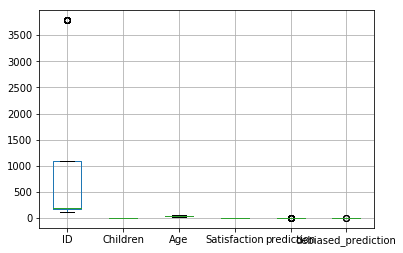

In [116]:
%matplotlib inline

pandas_df.boxplot()

### 7.2 Accessing data mart metrics
- performance
- quality
- fairness

#### Get all metrics

In [117]:
deployments_metrics = client.data_mart.get_deployment_metrics()

#### Get metric for particular deployment

In [118]:
subscription.quality_monitoring.get_metrics(deployment_uid=subscription.get_deployment_uids()[0])

{'end': '2018-12-13T15:43:33.410822Z',
 'metrics': [{'process': 'Accuracy_evaluation_42b3353a-96dd-4819-b10d-f2968aae8589',
   'timestamp': '2018-12-13T15:29:13.498Z',
   'value': {'metrics': [{'name': 'weightedTruePositiveRate', 'value': 0.5},
     {'name': 'accuracy', 'value': 0.5},
     {'name': 'weightedFMeasure', 'value': 0.625},
     {'name': 'weightedRecall', 'value': 0.5},
     {'name': 'weightedFalsePositiveRate', 'value': 0.0},
     {'name': 'weightedPrecision', 'value': 1.0}],
    'quality': 0.5,
    'threshold': 0.7}}],
 'start': '2018-12-13T14:29:10.858Z'}

In [119]:
subscription.performance_monitoring.get_metrics(deployment_uid=subscription.get_deployment_uids()[0])

{'end': '2018-12-13T15:44:19.828844Z',
 'metrics': [{'asset_revision': '994d1093-4f0c-48a1-8ed1-fa301f9fde5c',
   'timestamp': '2018-12-13T15:29:40.838Z',
   'value': {'records': 24, 'response_time': 1446.0}},
  {'asset_revision': '994d1093-4f0c-48a1-8ed1-fa301f9fde5c',
   'timestamp': '2018-12-13T15:29:39.525Z',
   'value': {'records': 60, 'response_time': 3708.0}},
  {'asset_revision': '994d1093-4f0c-48a1-8ed1-fa301f9fde5c',
   'timestamp': '2018-12-13T15:29:39.819Z',
   'value': {'records': 64, 'response_time': 4053.0}},
  {'asset_revision': '994d1093-4f0c-48a1-8ed1-fa301f9fde5c',
   'timestamp': '2018-12-13T15:29:40.321Z',
   'value': {'records': 60, 'response_time': 3573.0}},
  {'asset_revision': '994d1093-4f0c-48a1-8ed1-fa301f9fde5c',
   'timestamp': '2018-12-13T15:30:22.983Z',
   'value': {'records': 24, 'response_time': 1454.0}}],
 'start': '2018-12-13T14:29:10.858Z'}

---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.